In [1]:
#step 2 -----dataset creation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# NumPy → signal creation
# Pandas → dataset storage
# Matplotlib → visualization

In [3]:
#GENERATE CLEAN RF SIGNAL
fs = 1000  # sampling frequency
t = np.linspace(0, 1, fs)

# Clean RF signal (sine wave)
signal_clean = np.sin(2 * np.pi * 50 * t)

In [4]:
# RF signal is represented as a sine wave
# 50 Hz = base frequency
# This is a non-interference signal

In [5]:
#ADD INTERFERENCE TYPES
# Narrowband interference
narrowband = signal_clean + 0.5 * np.sin(2 * np.pi * 200 * t)

# Broadband interference (noise)
broadband = signal_clean + np.random.normal(0, 0.5, fs)

# Impulsive interference (spikes)
impulsive = signal_clean.copy()
impulsive[np.random.randint(0, fs, 20)] += 2

In [6]:
# Narrowband → extra frequency
# Broadband → noise across frequencies
# Impulsive → sudden spikes

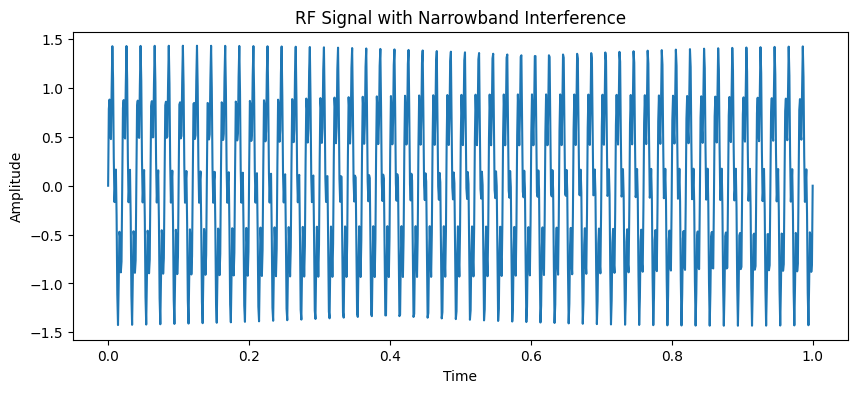

In [7]:
#VISULAIZING 
plt.figure(figsize=(10,4))
plt.plot(t, narrowband)
plt.title("RF Signal with Narrowband Interference")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
#This helps you see interference.

In [8]:
#DATA SET CREATION WITH LABELS
data = []

for i in range(fs):
    data.append([signal_clean[i], 0])   # No interference
    data.append([narrowband[i], 1])     # Narrowband
    data.append([broadband[i], 2])      # Broadband
    data.append([impulsive[i], 3])      # Impulsive

df = pd.DataFrame(data, columns=["signal_value", "label"])

In [9]:
# | Label | Meaning    |
# | ----- | ---------- |
# | 0     | Clean      |
# | 1     | Narrowband |
# | 2     | Broadband  |
# | 3     | Impulsive  |

In [10]:
import os

base_path = os.path.abspath("..")  # go one folder up
data_path = os.path.join(base_path, "data", "raw")

os.makedirs(data_path, exist_ok=True)

df.to_csv(os.path.join(data_path, "rfi_signal_dataset.csv"), index=False)#saving the created dataset.

In [11]:
#step 3 of the signal processing and visualization

In [12]:
sample_signal = narrowband

In [13]:
#LOAD ONE SIGNAL SAMPLE

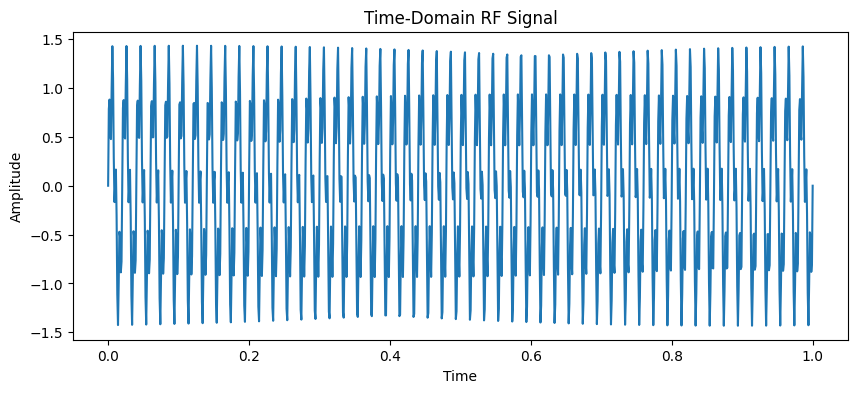

In [14]:
#TIME-DOMAIN PLOT 
plt.figure(figsize=(10,4))
plt.plot(t, sample_signal)
plt.title("Time-Domain RF Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

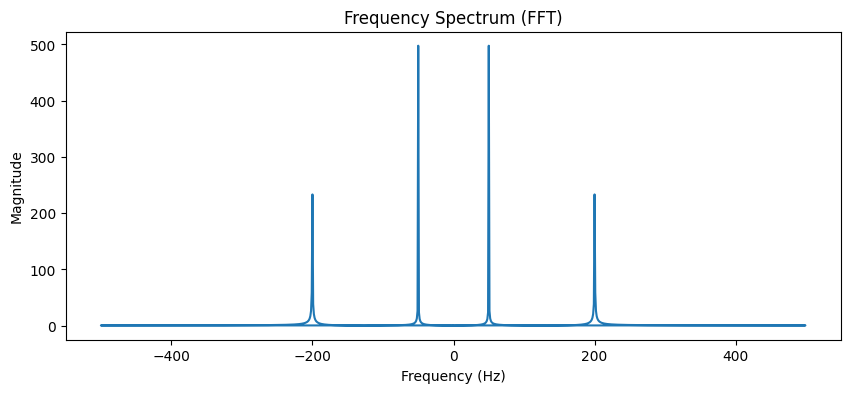

In [15]:
#FFT – FREQUENCY DOMAIN 
from scipy.fft import fft, fftfreq

yf = fft(sample_signal)
xf = fftfreq(len(sample_signal), 1/fs)

plt.figure(figsize=(10,4))
plt.plot(xf, np.abs(yf))
plt.title("Frequency Spectrum (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

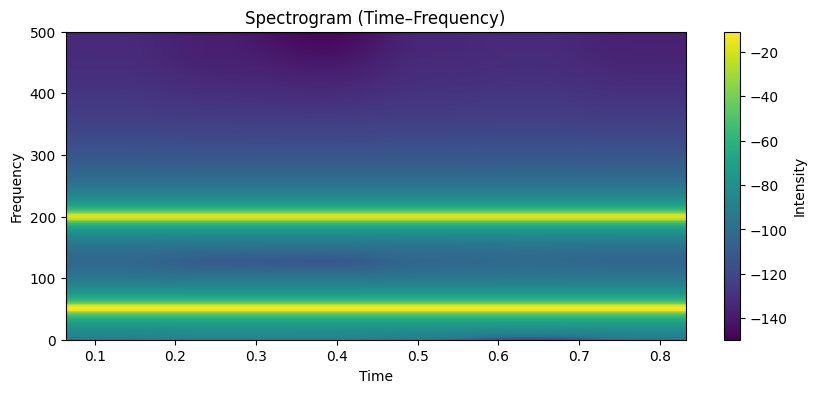

In [16]:
#SPECTROGRAM 
plt.figure(figsize=(10,4))
plt.specgram(sample_signal, Fs=fs)
plt.title("Spectrogram (Time–Frequency)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(label="Intensity")
plt.show()

In [17]:
plt.figure(figsize=(10,4))
plt.plot(xf, np.abs(yf))
plt.savefig(r"D:\AI_RFI_Detection_Project\results\fft_plot1.png")
plt.close()

In [18]:
#step 4
from scipy.stats import kurtosis, skew

In [19]:
# skew → measures signal asymmetry
# kurtosis → measures spikes (VERY important for impulsive interference)

In [20]:
#EXTRACT FEATURES FROM ONE SIGNAL 
features = {
    "mean": np.mean(sample_signal),
    "std": np.std(sample_signal),
    "max": np.max(sample_signal),
    "min": np.min(sample_signal),
    "skewness": skew(sample_signal),
    "kurtosis": kurtosis(sample_signal)
}
features

{'mean': 1.1106671138350066e-15,
 'std': 0.7901740314639556,
 'max': 1.432077303799564,
 'min': -1.4320773037995644,
 'skewness': -7.417015293049531e-16,
 'kurtosis': -1.0180180180180192}

In [21]:
# #why this above cell run
# | Feature  | Meaning (Simple)                      |
# | -------- | ------------------------------------- |
# | Mean     | Average signal level                  |
# | Std      | How much signal varies                |
# | Max      | Highest peak                          |
# | Min      | Lowest dip                            |
# | Skewness | Signal imbalance                      |
# | Kurtosis | Sharp spikes (interference indicator) |


In [22]:
#FEATURE EXTRACTION FOR FULL DATASET
def extract_features(signal):
    return [
        np.mean(signal),
        np.std(signal),
        np.max(signal),
        np.min(signal),
        skew(signal),
        kurtosis(signal)
    ]

X = []
y = []

signals = [signal_clean, narrowband, broadband, impulsive]
labels = [0, 1, 2, 3]

for signal, label in zip(signals, labels):
    X.append(extract_features(signal))
    y.append(label)

X = np.array(X)
y = np.array(y)

In [23]:
# Converts each signal into feature vector
# Prepares data for ML model

In [24]:
#SAVE FEATURE DATASET
feature_df = pd.DataFrame(
    X,
    columns=["mean", "std", "max", "min", "skewness", "kurtosis"]
)

feature_df["label"] = y
feature_df.to_csv(r"D:\AI_RFI_Detection_Project\data\processed/rfi_features.csv", index=False)

In [25]:
# #Clean ML-ready dataset
# Separates raw data and processed data

In [27]:
# #step 5
# LOAD FEATURE DATASET
features_df = pd.read_csv(r"D:\AI_RFI_Detection_Project\data\processed/rfi_features.csv")
features_df

,mean,std,max,min,skewness,kurtosis,label
0,4.574119e-17,0.706753,0.999999,-0.999999,2.239170e-16,-1.498498,0
1,1.110667e-15,0.790174,1.432077,-1.432077,-7.417015e-16,-1.018018,1
2,2.187679e-02,0.868103,2.213457,-2.358697,-3.173377e-02,-0.671916,2
3,4.000000e-02,0.750214,2.923126,-0.999999,2.562944e-01,-0.592463,3


In [28]:
# Loads processed features
# This is what ML models actually learn from
# | mean | std | max | min | skewness | kurtosis | label |
# | ---- | --- | --- | --- | -------- | -------- | ----- |

In [29]:
#CREATE DETECTION LABEL
# Convert multiclass labels to binary
features_df["detection_label"] = features_df["label"].apply(
    lambda x: 0 if x == 0 else 1
)

features_df[["label", "detection_label"]]

,label,detection_label
0,0,0
1,1,1
2,2,1
3,3,1


In [30]:
# Converts problem into YES / NO

# Simplifies detection logic

# Output meaning
# label	detection_label
# 0	0 → No interference
# 1/2/3	1 → Interference

In [31]:
# SPLIT DATA FOR TRAINING & TESTING 
from sklearn.model_selection import train_test_split

X = features_df[["mean", "std", "max", "min", "skewness", "kurtosis"]]
y = features_df["detection_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [32]:
# Train data → model learns
# Test data → model evaluation
# # Prevents overfitting

In [33]:
# TRAIN RANDOM FOREST DETECTION MODEL
from sklearn.ensemble import RandomForestClassifier

rf_detector = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_detector.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# WHY Random Forest?
# Handles noisy data well
# Works great for signal features
# Less tuning needed
# # Examiner-approved

In [35]:
# MAKE PREDICTIONS
y_pred = rf_detector.predict(X_test)

In [36]:
# WHY we ran this
# Generates YES / NO predictions
# Used for accuracy and confusion matrix

In [37]:
#accuracy & metrics
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print("Detection Accuracy:", accuracy)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Detection Accuracy: 0.5

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.50      0.67         2

    accuracy                           0.50         2
   macro avg       0.50      0.25      0.33         2
weighted avg       1.00      0.50      0.67         2



C:\Users\User\OneDrive\Desktop\MY_SPACE\codes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\OneDrive\Desktop\MY_SPACE\codes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\OneDrive\Desktop\MY_SPACE\codes\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [38]:
# Accuracy → Overall correctness
# Precision → False alarms?
# Recall → Missed interference?
# F1-score → Balance

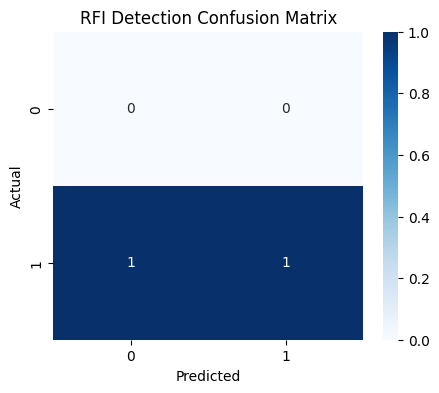

In [40]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RFI Detection Confusion Matrix")
plt.show()
#Shows correct vs wrong predictions

In [42]:
#saving model
import joblib

joblib.dump(rf_detector, r"D:\AI_RFI_Detection_Project\models\rfi_detector.pkl")


# WHY we save model
# Dashboard will load it
# No retraining every time

['D:\\AI_RFI_Detection_Project\\models\\rfi_detector.pkl']